# Conformal prediction for Regressors

### Imports

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

### Train and test datasets

In [2]:
housing = fetch_california_housing(data_home='data/california_housing')
print(f"Shapes: {housing.data.shape}, {housing.target.shape}")
print("Feature names:", housing.feature_names)
print("Target names:", housing.target_names)

Shapes: (20640, 8), (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target names: ['MedHouseVal']


In [3]:
# Treure random_state

In [5]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.2, random_state=0)

## Gradient Boosting Regressor

### Hyperparameters and loss function

In [6]:
learning_rate = 0.1
n_estimators = 200

In [7]:
loss = 'quantile'

In [8]:
alpha = 0.1
lq = alpha/2
uq = 1-lq
print(f"Lower quantile: {lq}, upper quantile: {uq}, coverage: {1-alpha}")

Lower quantile: 0.05, upper quantile: 0.95, coverage: 0.9


### Training

In [9]:
gbr_lq = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, alpha=lq)
gbr_uq = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, alpha=uq)
gbr = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators)

gbr_lq.fit(X_train, y_train)
gbr_uq.fit(X_train, y_train)
gbr.fit(X_train, y_train)

print("Done")

Done


### Predictions

In [10]:
y_lower = gbr_lq.predict(X_test)
y_upper = gbr_uq.predict(X_test)
y_pred = gbr.predict(X_test)

**No hi ha manera de visualitzar-ho bé**

In [11]:
#fig = plt.figure(figsize=(10, 10))
#plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
#plt.plot(X_test, y_upper, "k-")
#plt.plot(X_test, y_lower, "k-")
#plt.fill_between(
#    X_test.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
#)
#plt.xlabel("$x$")
#plt.ylabel("$f(x)$")
#plt.ylim(-10, 25)
#plt.legend(loc="upper left")
#plt.show()

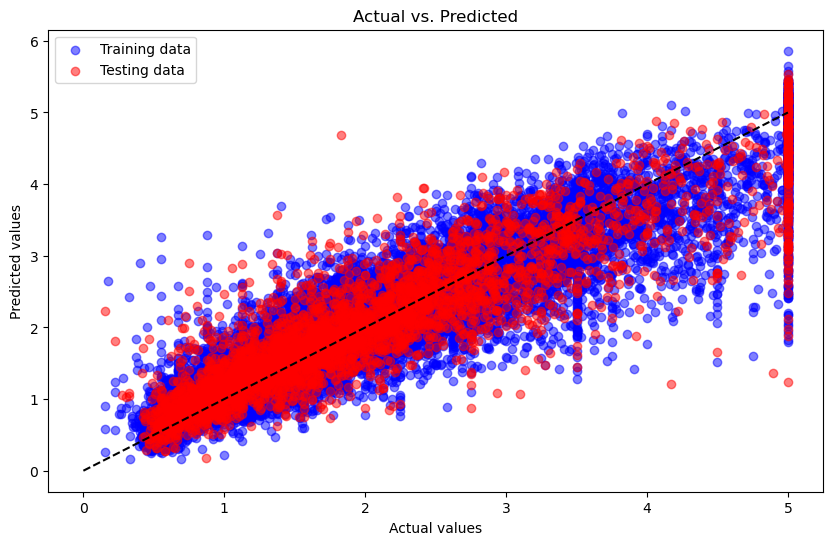

In [12]:
# Scatter plot for training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train, gbr.predict(X_train), color='blue', alpha=0.5, label='Training data')
# Scatter plot for testing data
plt.scatter(y_test, gbr.predict(X_test), color='red', alpha=0.5, label='Testing data')

# Plotting the perfect fit line
maX_test = max(y_train.max(), y_test.max())
plt.plot([0, maX_test], [0, maX_test], color='black', linestyle='--')

plt.title('Actual vs. Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()


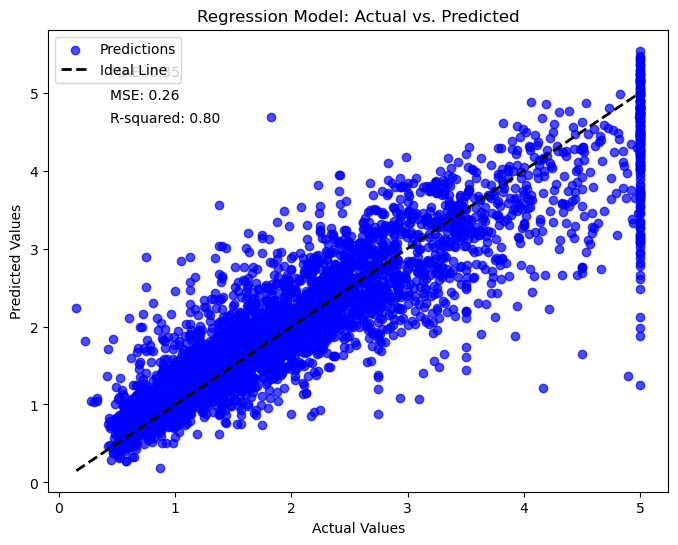

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have y_test (actual values) and y_pred (predicted values)
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Regression Model: Actual vs. Predicted')
plt.legend()

# Display evaluation metrics
plt.text(0.1, 0.9, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.85, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'R-squared: {r2:.2f}', transform=plt.gca().transAxes)

plt.show()

## Conformal prediction and uncertainty quantification

In [14]:
len(X_test)

4128

In [15]:
num_samples = 100

In [16]:
X_calib, y_calib = X_test[:num_samples], y_test[:num_samples]

In [55]:
y_lq = gbr_lq.predict(X_calib)
y_uq = gbr_uq.predict(X_calib)
y_fill = list(zip(y_lq, y_uq))

In [51]:
scores = [max(l_pred-y, y-u_pred) for (l_pred, u_pred), y in zip(y_fill, y_calib)]

In [42]:
p = 1-alpha
print(p)

0.9


In [43]:
p_hat = ceil((num_samples+1)*p) / num_samples
print(p_hat)

0.91


In [44]:
q_hat = np.quantile(scores, p_hat, method='higher')
print(q_hat)

0.08556349118936879


### Getting prediction sets

In [57]:
X_remain, y_remain = X_test[num_samples:], y_test[num_samples:]

In [65]:
gbr_lq.predict(X_remain) - 1

array([ 0.19840382,  0.34674874,  0.13456461, ..., -0.10646574,
        1.03008759,  0.27170871])

In [70]:
y_lq = gbr_lq.predict(X_remain) - q_hat
y_uq = gbr_uq.predict(X_remain) + q_hat
y_fill = list(zip(y_lq, y_uq))

In [71]:
y_fill

[(1.1128403280536614, 2.607196412386366),
 (1.2611852513090747, 3.090291591817929),
 (1.0490011191608206, 2.4353318527569714),
 (1.6510957765260104, 4.580052227771774),
 (1.437812167208979, 3.0841722285837956),
 (1.834172534872162, 3.3603667724459223),
 (1.037984864358146, 2.917924138945369),
 (0.48543116567957956, 2.1377730857278125),
 (0.5721405779089738, 1.4690285329512982),
 (1.006280544982043, 2.8942438339438743),
 (1.5994366840792387, 3.55700285938763),
 (0.3821494012443738, 2.4083547899012236),
 (1.2413706457791862, 3.268109881441373),
 (1.881049715760633, 5.19024901856508),
 (1.1057364397914826, 2.3660116574987358),
 (2.031525807690122, 4.759270107757483),
 (0.9353155533842772, 1.6368572931595893),
 (1.2491965697774365, 2.9728717842048695),
 (0.9732518745405467, 2.58298854603703),
 (0.7579194956852886, 2.237650607386101),
 (1.8573814664254114, 3.557009120054583),
 (0.7468736144464209, 3.1446747746638093),
 (1.1904900856199607, 3.751380618691173),
 (1.1286068850968651, 4.2304807